#### part1: image cartoonifying

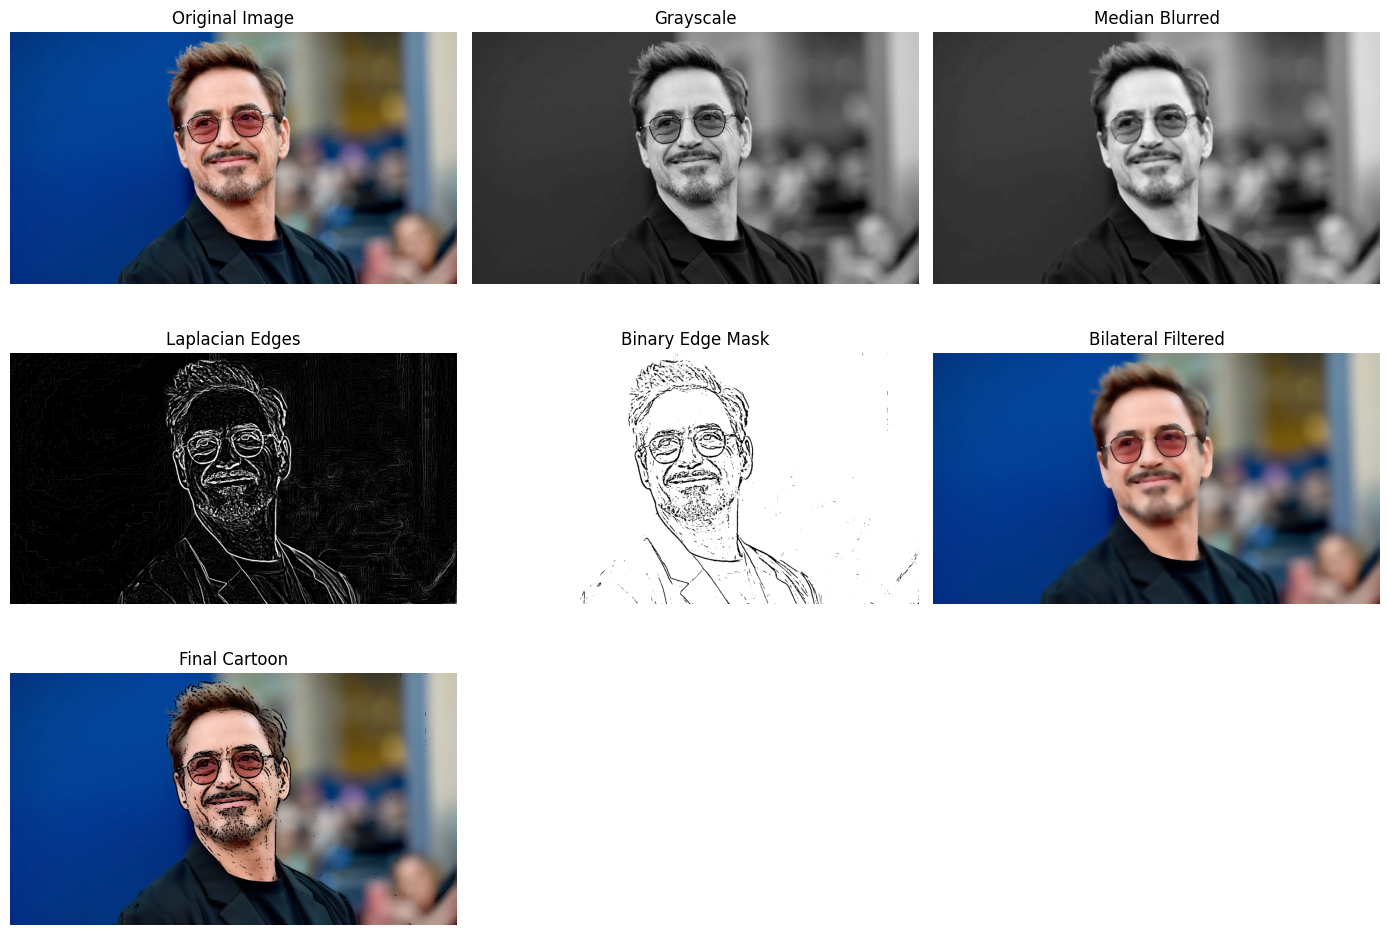

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Part I: Image Cartoonifying
# -------------------------------

def cartoonify_image_steps(img, 
                           median_ksize=7, 
                           laplacian_ksize=5, 
                           threshold_val=100,
                           bilateral_d=9, 
                           bilateral_sigmaColor=75, 
                           bilateral_sigmaSpace=75, 
                           num_bilateral=5):
    """
    Process the input image through several steps to obtain a cartoon effect.
    Returns a dictionary of intermediate images.
    Steps:
    1. Original image
    2. Grayscale conversion
    3. Median blurred grayscale image
    4. Laplacian filter result (raw edges)
    5. Binary edge mask (sketch)
    6. Color image after repeated bilateral filtering
    7. Final cartoon image (bilateral filtered image combined with edge mask)
    """
    steps = {}
    steps['original'] = img.copy()
    
    # 1. Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    steps['grayscale'] = gray.copy()
    
    # 2. Apply median filter to reduce noise
    gray_blur = cv2.medianBlur(gray, median_ksize)
    steps['median_blur'] = gray_blur.copy()
    
    # 3. Apply Laplacian filter for edge detection
    laplacian = cv2.Laplacian(gray_blur, cv2.CV_8U, ksize=laplacian_ksize)
    steps['laplacian'] = laplacian.copy()
    
    # 4. Apply binary thresholding to create a clear edge mask (sketch)
    ret, edge_mask = cv2.threshold(laplacian, threshold_val, 255, cv2.THRESH_BINARY_INV)
    steps['edge_mask'] = edge_mask.copy()
    
    # 5. Apply repeated bilateral filtering to smooth the color regions while preserving edges
    bilateral_img = img.copy()
    for i in range(num_bilateral):
        bilateral_img = cv2.bilateralFilter(bilateral_img, bilateral_d, bilateral_sigmaColor, bilateral_sigmaSpace)
    steps['bilateral'] = bilateral_img.copy()
    
    # 6. Combine the bilateral filtered image with the edge mask to get the final cartoon effect
    edge_mask_color = cv2.cvtColor(edge_mask, cv2.COLOR_GRAY2BGR)
    cartoon = cv2.bitwise_and(bilateral_img, edge_mask_color)
    steps['cartoon'] = cartoon.copy()
    
    return steps

def display_cartoon_steps(steps):
    """
    Displays the intermediate results for the cartoonification process.
    """
    titles = [
        "Original Image", 
        "Grayscale", 
        "Median Blurred", 
        "Laplacian Edges", 
        "Binary Edge Mask", 
        "Bilateral Filtered", 
        "Final Cartoon"
    ]
    
    images = [steps['original'], 
              steps['grayscale'], 
              steps['median_blur'], 
              steps['laplacian'], 
              steps['edge_mask'], 
              steps['bilateral'], 
              steps['cartoon']]
    
    # Determine subplot grid size (e.g., 3 rows x 3 cols if needed)
    plt.figure(figsize=(14, 10))
    for i in range(len(images)):
        plt.subplot(3, 3, i+1)
        # Check if the image is grayscale or color:
        if len(images[i].shape) == 2:
            plt.imshow(images[i], cmap='gray')
        else:
            # Convert BGR to RGB for display
            plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()


# -------------------------------
# Main Function to Run the Processes
# -------------------------------

def display_results_cartoonify():
    # ----- Part I: Cartoonification -----
    cartoon_input_path = 'robert.webp'  # Change to your input file name
    img = cv2.imread(cartoon_input_path)
    if img is None:
        print(f"Error: Cartoon input image not found. Ensure '{cartoon_input_path}' exists.")
    else:
        cartoon_steps = cartoonify_image_steps(img)
        # Optionally, save intermediate images:
        cv2.imwrite('cartoon_original.jpg', cartoon_steps['original'])
        cv2.imwrite('cartoon_grayscale.jpg', cartoon_steps['grayscale'])
        cv2.imwrite('cartoon_median.jpg', cartoon_steps['median_blur'])
        cv2.imwrite('cartoon_laplacian.jpg', cartoon_steps['laplacian'])
        cv2.imwrite('cartoon_edge_mask.jpg', cartoon_steps['edge_mask'])
        cv2.imwrite('cartoon_bilateral.jpg', cartoon_steps['bilateral'])
        cv2.imwrite('cartoon_final.jpg', cartoon_steps['cartoon'])
        
        display_cartoon_steps(cartoon_steps)
    
   

display_results_cartoonify()



Median Filter
 - What It Does:
 The median filter is a non-linear filter used primarily for noise reduction. It works exceptionally well at removing “salt and pepper” noise (random bright and dark spots) without blurring the edges as much as linear filters (like Gaussian filters) might.

 - How It Works:

  The filter works by sliding a window (kernel) over the image.
  For each pixel, it considers the intensities of the pixels in the window.
  It then replaces the center pixel’s value with the median value of those intensities.
  Because the median is less sensitive to outliers than the mean, the filter can remove noise while preserving sharp boundaries.

Laplacian Filter
 - What It Does:
 The Laplacian filter is a second-order derivative operator used for edge detection. It highlights areas of rapid intensity change in an image, which typically correspond to edges.

 - How It Works:

 The Laplacian operator computes the second derivative of the image intensity.

 This operation emphasizes regions where the intensity changes rapidly (i.e., edges).
 However, because second derivatives are highly sensitive to noise, applying the Laplacian filter directly to a noisy image could result in many false edges—hence the prior use of the median filter.
 Once the raw edges are computed, a binary threshold is applied to create a sketch-like (black-and-white) effect by converting the grayscale edges into a crisp mask where pixels are either “edge” (white) or “non-edge” (black).

 Bilateral Filter
 - What It Does:
 The bilateral filter is an edge-preserving smoothing filter. It reduces image noise and detail in flat regions while keeping edges sharp.

 - How It Works:

 Unlike traditional filters that consider only the spatial proximity of pixels, the bilateral filter combines both spatial closeness and intensity similarity.
 It applies a weighted average where weights are determined by:
 Domain (Spatial) Weight: A Gaussian function of the distance between the center pixel and the neighboring pixels.
 Range (Intensity) Weight: A Gaussian function of the difference in intensity between the center pixel and its neighbors.

In [8]:
 # -------------------------------
# Part II: Road Lane Detection Using Hough Transform
# -------------------------------

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    Only keeps the region of the image defined by the polygon formed from vertices.
    The rest of the image is set to black.
    """
    mask = np.zeros_like(img)
    # If the image has more than one channel, create a tuple for the mask color.
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_img = cv2.bitwise_and(img, mask)
    return masked_img

def lane_detection_steps(image, 
                         median_ksize=9, 
                         canny_thresh1=50, 
                         canny_thresh2=150, 
                         hough_thresh=50, 
                         min_line_length=50, 
                         max_line_gap=20):
    """
    Processes the road image to detect lanes and returns intermediate steps.
    Steps:
    1. Original image
    2. Smoothed image using median filter
    3. Grayscale image
    4. Canny edge detection result
    5. Edges after applying the Region Of Interest (ROI) mask
    6. Final image with detected lanes drawn
    """
    steps = {}
    steps['original'] = image.copy()
    
    # 1. Smooth the image using a median filter
    smooth = cv2.medianBlur(image, median_ksize)
    steps['smoothed'] = smooth.copy()
    
    # 2. Convert to grayscale and apply Canny edge detection
    gray = cv2.cvtColor(smooth, cv2.COLOR_BGR2GRAY)
    steps['grayscale'] = gray.copy()
    edges = cv2.Canny(gray, canny_thresh1, canny_thresh2)
    steps['edges'] = edges.copy()
    
    # 3. Define a Region Of Interest (ROI) to focus on the road area
    height, width = edges.shape
    roi_vertices = np.array([[
        (int(0.1 * width), height),
        (int(0.45 * width), int(0.6 * height)),
        (int(0.55 * width), int(0.6 * height)),
        (int(0.9 * width), height)
    ]], dtype=np.int32)
    masked_edges = region_of_interest(edges, roi_vertices)
    steps['roi_edges'] = masked_edges.copy()
    
    # 4. Use Hough Transform to detect line segments
    lines = cv2.HoughLinesP(masked_edges, rho=1, theta=np.pi/180, threshold=hough_thresh,
                            minLineLength=min_line_length, maxLineGap=max_line_gap)
    
    # Draw the detected lines on a copy of the original image
    lane_img = image.copy()
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(lane_img, (x1, y1), (x2, y2), (0, 255, 0), thickness=3)
    steps['lane_detection'] = lane_img.copy()
    
    return steps

def display_lane_steps(steps):
    """
    Displays the intermediate results for the lane detection process.
    """
    titles = [
        "Original Road Image", 
        "Smoothed Image", 
        "Grayscale", 
        "Canny Edges", 
        "Edges in ROI", 
        "Lane Detection Output"
    ]
    
    images = [steps['original'], 
              steps['smoothed'], 
              steps['grayscale'], 
              steps['edges'], 
              steps['roi_edges'], 
              steps['lane_detection']]
    
    plt.figure(figsize=(14, 10))
    for i in range(len(images)):
        plt.subplot(2, 3, i+1)
        if len(images[i].shape) == 2:
            plt.imshow(images[i], cmap='gray')
        else:
            plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

 
 
 
def display_results_lane():
    
    lane_input_path = 'test_images/road3.webp'  # Change to your road image file name
    road_img = cv2.imread(lane_input_path)
    if road_img is None:
        print(f"Error: Road input image not found. Ensure '{lane_input_path}' exists.")
    else:
        lane_steps = lane_detection_steps(road_img)
        # Optionally, save intermediate images:
        cv2.imwrite('lane_original.jpg', lane_steps['original'])
        cv2.imwrite('lane_smoothed.jpg', lane_steps['smoothed'])
        cv2.imwrite('lane_grayscale.jpg', lane_steps['grayscale'])
        cv2.imwrite('lane_edges.jpg', lane_steps['edges'])
        cv2.imwrite('lane_roi_edges.jpg', lane_steps['roi_edges'])
        cv2.imwrite('lane_final.jpg', lane_steps['lane_detection'])
        
        display_lane_steps(lane_steps)

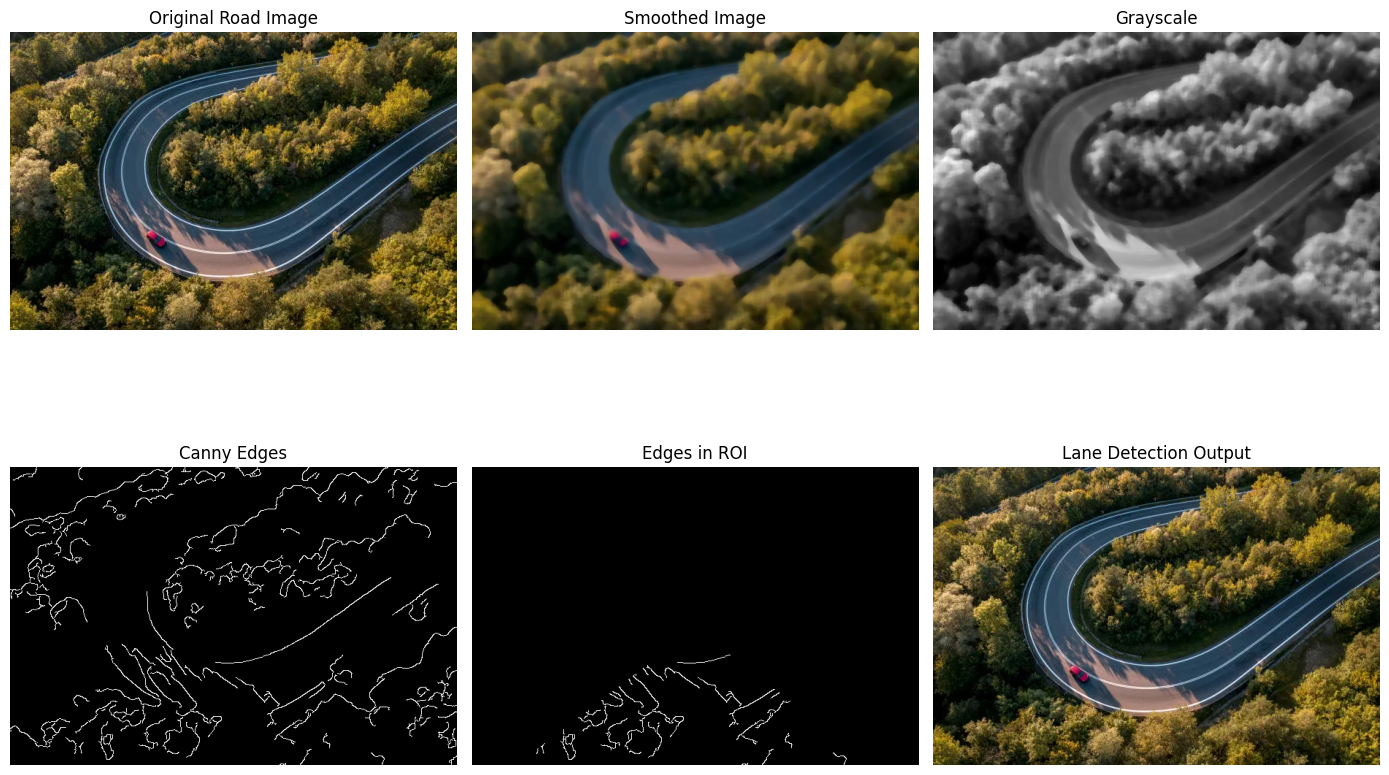

In [11]:

display_results_lane()

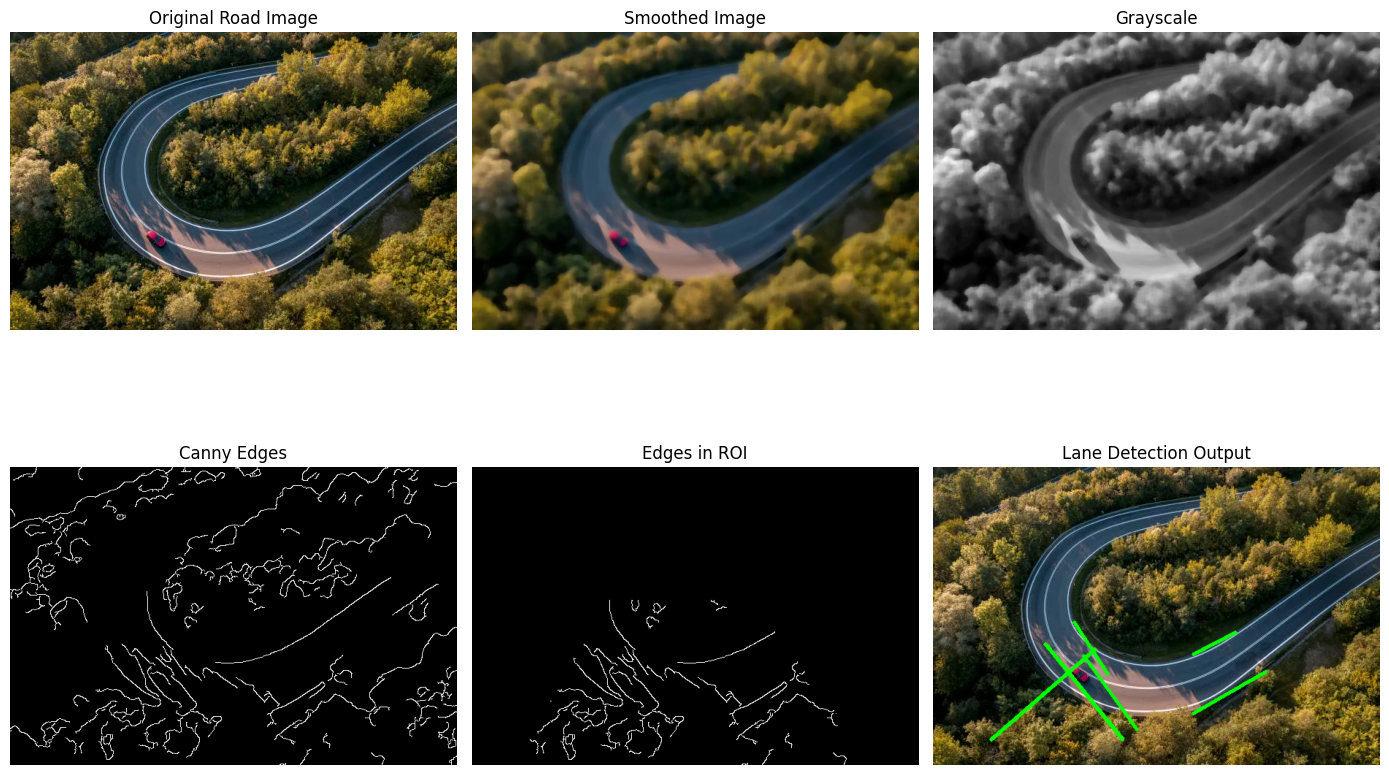

In [14]:
def detect_vanishing_point(edges):
    """
    Detects the vanishing point by finding the intersection of lane lines using the Hough Transform.
    """
    # Detect lines using the Hough Transform
    lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=50, minLineLength=50, maxLineGap=150)
    
    if lines is None:
        return None  # No vanishing point detected

    # Convert lines into slope-intercept form: y = mx + b
    slopes = []
    intercepts = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        if x2 - x1 == 0:  # Avoid division by zero (vertical lines)
            continue
        m = (y2 - y1) / (x2 - x1)  # Slope
        b = y1 - m * x1  # Intercept
        slopes.append(m)
        intercepts.append(b)

    # Find intersections (vanishing point)
    vanishing_x = []
    vanishing_y = []
    for i in range(len(slopes)):
        for j in range(i + 1, len(slopes)):
            if slopes[i] == slopes[j]:  # Parallel lines won't intersect
                continue
            # Solve for intersection: m1*x + b1 = m2*x + b2
            x_intersect = (intercepts[j] - intercepts[i]) / (slopes[i] - slopes[j])
            y_intersect = slopes[i] * x_intersect + intercepts[i]
            vanishing_x.append(x_intersect)
            vanishing_y.append(y_intersect)

    if len(vanishing_x) == 0:
        return None  # No valid intersections found

    # Average all intersection points to get a stable vanishing point
    vanishing_point = (int(np.mean(vanishing_x)), int(np.mean(vanishing_y)))
    return vanishing_point

def get_dynamic_roi(image, vanishing_point):
    """
    Dynamically generates a trapezoidal ROI based on the detected vanishing point.
    """
    height, width = image.shape[:2]

    if vanishing_point is None:
        # If no vanishing point detected, use a default trapezoidal ROI
        roi_vertices = np.array([[
            (int(0.1 * width), height),   # Bottom left
            (int(0.4 * width), int(0.6 * height)),  # Top left
            (int(0.6 * width), int(0.6 * height)),  # Top right
            (int(0.9 * width), height)    # Bottom right
        ]], dtype=np.int32)
    else:
        # Define trapezoidal ROI dynamically using the vanishing point
        vp_x, vp_y = vanishing_point
        roi_vertices = np.array([[
            (int(0.1 * width), height),   # Bottom left
            (vp_x - 100, vp_y ),      # Top left (offset from vanishing point)
            (vp_x + 100, vp_y ),      # Top right (offset from vanishing point)
            (int(0.9 * width), height)    # Bottom right
        ]], dtype=np.int32)

    return roi_vertices

def lane_detection_steps_dynamic_roi(image, 
                         median_ksize=9, 
                         canny_thresh1=50, 
                         canny_thresh2=150, 
                         hough_thresh=50, 
                         min_line_length=50, 
                         max_line_gap=20):
    """
    Processes the road image to detect lanes and returns intermediate steps.
    Steps:
    1. Original image
    2. Smoothed image using median filter
    3. Grayscale image
    4. Canny edge detection result
    5. Edges after applying the Region Of Interest (ROI) mask
    6. Final image with detected lanes drawn
    """
    steps = {}
    steps['original'] = image.copy()
    
    # 1. Smooth the image using a median filter
    smooth = cv2.medianBlur(image, median_ksize)
    steps['smoothed'] = smooth.copy()
    
    # 2. Convert to grayscale and apply Canny edge detection
    gray = cv2.cvtColor(smooth, cv2.COLOR_BGR2GRAY)
    steps['grayscale'] = gray.copy()
    edges = cv2.Canny(gray, canny_thresh1, canny_thresh2)
    steps['edges'] = edges.copy()
    
    # 3. Define a Region Of Interest (ROI) to focus on the road area
    vanishing_point = detect_vanishing_point(edges)

    # Get dynamic ROI
    roi_vertices = get_dynamic_roi(image, vanishing_point)
    
        
    masked_edges = region_of_interest(edges, roi_vertices)
    steps['roi_edges'] = masked_edges.copy()
    
    # 4. Use Hough Transform to detect line segments
    lines = cv2.HoughLinesP(masked_edges, rho=1, theta=np.pi/180, threshold=hough_thresh,
                            minLineLength=min_line_length, maxLineGap=max_line_gap)
    
    # Draw the detected lines on a copy of the original image
    lane_img = image.copy()
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(lane_img, (x1, y1), (x2, y2), (0, 255, 0), thickness=3)
    steps['lane_detection'] = lane_img.copy()
    
    return steps


 
 
 
def display_results_lane_dynamic():
    
    lane_input_path = 'test_images/road3.webp'  # Change to your road image file name
    road_img = cv2.imread(lane_input_path)
    if road_img is None:
        print(f"Error: Road input image not found. Ensure '{lane_input_path}' exists.")
    else:
        lane_steps = lane_detection_steps(road_img)
        # Optionally, save intermediate images:
        cv2.imwrite('lane_original.jpg', lane_steps['original'])
        cv2.imwrite('lane_smoothed.jpg', lane_steps['smoothed'])
        cv2.imwrite('lane_grayscale.jpg', lane_steps['grayscale'])
        cv2.imwrite('lane_edges.jpg', lane_steps['edges'])
        cv2.imwrite('lane_roi_edges.jpg', lane_steps['roi_edges'])
        cv2.imwrite('lane_final.jpg', lane_steps['lane_detection'])
        
        display_lane_steps(lane_steps)
        
display_results_lane_dynamic()